# WiFi Locationing
<div style="text-align: right"> Ariadna Fernández </div>

# Table of Contents
1. [Summary](#Summary)
2. [Loading Libraries, Functions and Data](#Loading-Libraries)
3. [Data exploration](#Data-Exploration)
4. [Pre-processing & Feature Engineering](#Pre-processing)
5. [Modelling](#Modelling)
6. [Error Analysis](#Error-Analysis)
7. [Conclusions](#Conclusions)

## Summary

Automatic user localization consists on estimating the position of a person by using an electronic device, usually a mobile phone. Outdoor localization problem can be solved very accurately as a result of the inclusion of GPS sensors into the mobile devices. However, indoor localization is a different issue mainly because of the loss of GPS signal in indoor environments, thus arising the need of finding other alternatives.

In this project, we intend to use the fingerprint of Web Access Points (WAPs) to predict the position of a mobile device holder. The fingerprint of WAP is the Received Signal Strength Indicator (RSSI). We will evaluate the application of machine learning techniques to the problem of indoor locationing via wifi fingerprinting, developing a Wi-Fi Fingerprinting model to locate people indoors in 3 large buildings in the campus of Universitat Jaume I (UJI).

The UJIIndoorLoc database covers 3 buildings of UJI with 4 or more floors and almost 110,000 m2. We started with a complete Exploratory Data Analysis (EDA) by exploring the data distribution. Each WiFi fingerprint is characterized by the detected Wireless Access Points (WAPs) and the corresponding Received Signal Strength Intensity (RSSI). The intensity values are represented as negative integer values ranging from -104dBm (extremely poor signal) to 0dbM. The positive value 100 is used to denote when a WAP was not detected. During the database creation, 520 different WAPs were detected. Thus, the WiFi fingerprint is composed of 520 intensity values.

Carefull Data Preprocessing and Feature Engineer was performed, followed by Machine Learning algorithms tuning, obtaining a perfect accuracy for Building prediction. Floor predictions accuracies yielded values of 94%, while latitude and longitude predictions failed mainly in some specific areas, obtaining a RMSE of 7.5 and 7.6, respectively.



## Loading Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl #https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from plotly.offline import plot

from sklearn.utils import resample
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

from math import sqrt,pi

## Functions

In [56]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Importing the Data

In [2]:
training_raw = pd.read_csv("./Data/trainingData.csv")
validation_raw = pd.read_csv("./Data/validationData.csv")

In [3]:
training_raw.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [4]:
training_raw.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [7]:
# Check missing values
training_raw.isnull().any().sum()
validation_raw.isnull().any().sum()

0

In [3]:
#Change data types of categorical variables
training_raw.FLOOR = training_raw.FLOOR.astype('category')
training_raw.BUILDINGID = training_raw.BUILDINGID.astype('category')

validation_raw.FLOOR = validation_raw.FLOOR.astype('category')
validation_raw.BUILDINGID = validation_raw.BUILDINGID.astype('category')

## Data Exploration

- We need to predict Building, Floor, Latitude and Longitude, therefore, we need to pay speciall attention to the distribution of these variables.
- In this section, a mapping of the Buildings is performed.
- Data is distributed in 520 WAPS and some other categorical variables, such as Phone ID, User ID, Space ID, Relative Position and Timestamp.
- Analysis on these attributes was performed in a previous script, and found that some of this data changes from Training to Validation datasets, so it was not considered.

### Data Distribution

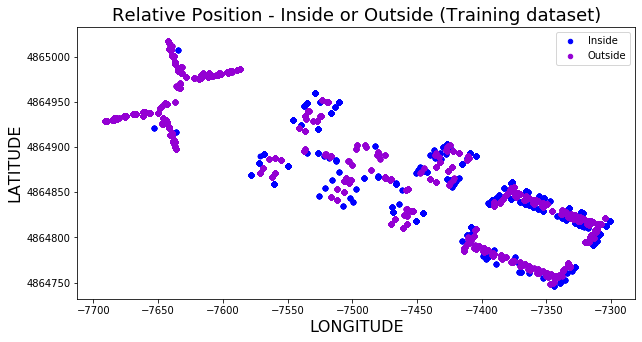

In [40]:
# Create subset for inside and outside
Pos01_in_train = training_raw[training_raw['RELATIVEPOSITION'] == 1]
Pos02_out_train = training_raw[training_raw['RELATIVEPOSITION'] == 2]

ax1 = Pos01_in_train.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                          label='Inside',
                          color='blue',
                          figsize=(10, 5))
ax2 = Pos02_out_train.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                           label='Outside',
                           color="darkviolet",
                           figsize=(10, 5),
                           ax=ax1)

plt.title('Relative Position - Inside or Outside (Training dataset)', fontsize=18)
plt.xlabel('LONGITUDE', fontsize=16)
plt.ylabel('LATITUDE', fontsize=16)
plt.legend(loc='best')
plt.show()

- The location points were recorded two times, one time inside a certain room, and another time outside that room (in the corridor).
- This fact can be clearly observed in the above figure

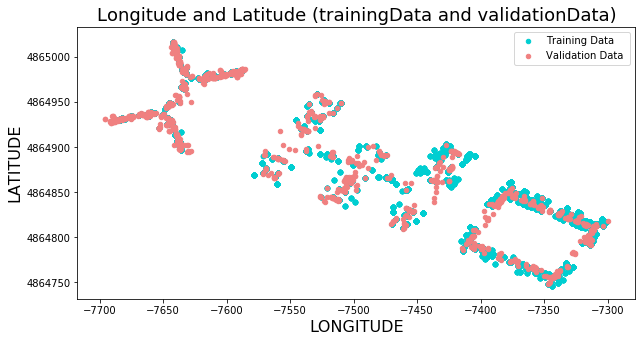

In [41]:
# CHECKING DISTRIBUTIONS OF THE TRAINING AND VALIDATIONS

ax1 = training_raw.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                        label='Training Data ',
                        color="darkturquoise",
                        figsize=(10, 5))
ax2 = validation_raw.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                          label='Validation Data ',
                          color="lightcoral",
                          figsize=(10, 5),
                          ax=ax1)

plt.title("Longitude and Latitude (trainingData and validationData)", fontsize=18)
plt.xlabel('LONGITUDE', fontsize=16)
plt.ylabel('LATITUDE', fontsize=16)
plt.legend(loc='best')

plt.show()

- The distribution of the validation data and the training data is quite similar, with one single exception: validation data has more observations on the Building 00 than the training data. This pottentially could lead to a model performing well for Buildings 01 and 02, but no 00.

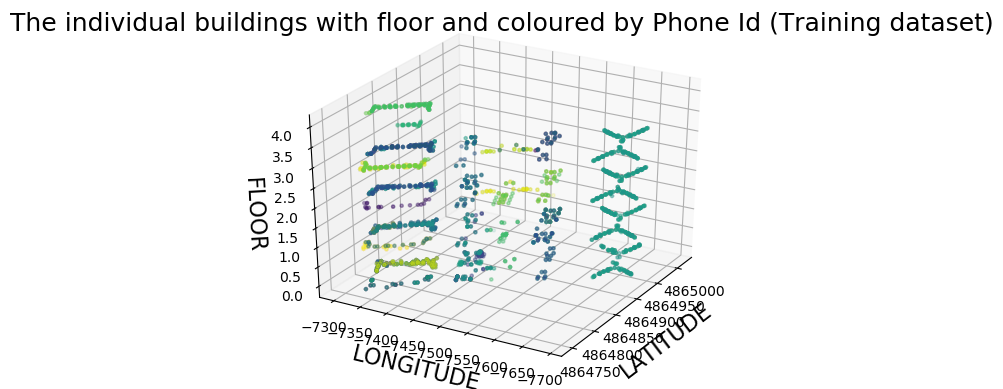

In [19]:
# PLOTTING THE FLOOR IN THE Z AXIS - TRAINING

mpl.style.use('default')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = training_raw['LATITUDE']
y = training_raw['LONGITUDE']
z = training_raw['FLOOR']
c = training_raw['PHONEID']  # color

ax.scatter(x, y, z, c=c, marker='o', s=5, alpha=0.05)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set rotation angle to -140 and 20 degrees
ax.view_init(azim=(-150))
ax.elev = 30

# Add the labels
ax.set_title("The individual buildings with floor and coloured by Phone Id (Training dataset)", fontsize=18)
ax.set_xlabel("LATITUDE", fontsize=16)
ax.set_ylabel("LONGITUDE", fontsize=16)
ax.set_zlabel("FLOOR", fontsize=16)

plt.show()

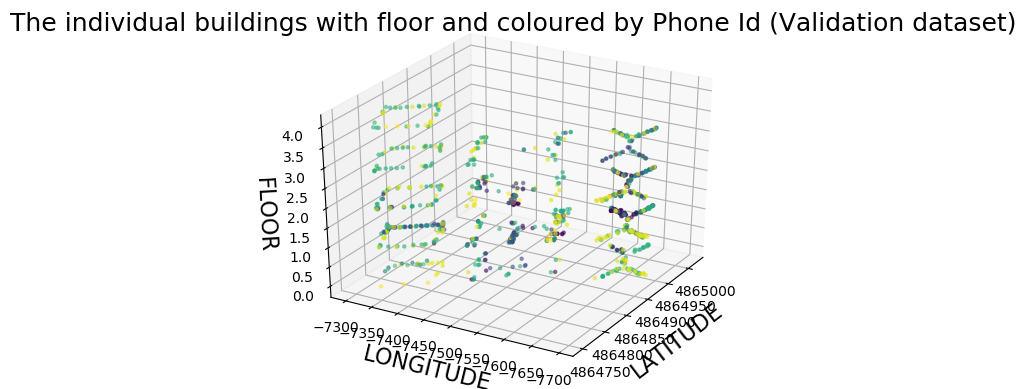

In [18]:
#PLOTTING THE FLOOR IN THE Z AXIS - VALIDATION

mpl.style.use('default')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = validation_raw['LATITUDE']
y = validation_raw['LONGITUDE']
z = validation_raw['FLOOR']
c = validation_raw['PHONEID'] #color

ax.scatter(x, y, z, c=c, marker='o', s=5, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set rotation angle to -140 and 20 degrees
ax.view_init(azim=(-150))
ax.elev = 30

# Add the labels
ax.set_title("The individual buildings with floor and coloured by Phone Id (Validation dataset)", fontsize=18)
ax.set_xlabel("LATITUDE", fontsize=16)
ax.set_ylabel("LONGITUDE", fontsize=16)
ax.set_zlabel("FLOOR", fontsize=16)

plt.show()

### Floor and Building Distribution

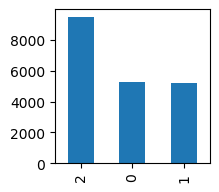

In [78]:
training_raw['BUILDINGID'].value_counts().plot(kind='bar', figsize=(2,2))

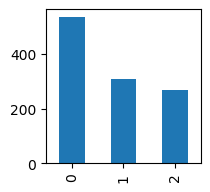

In [79]:
validation_raw['BUILDINGID'].value_counts().plot(kind='bar', figsize=(2,2))

- There is class imbalance for Building in both datasets, while training set has mor observations on Building 02, validation set has them in Building 00. 

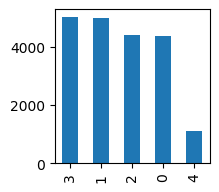

In [80]:
training_raw['FLOOR'].value_counts().plot(kind='bar', figsize=(2,2))

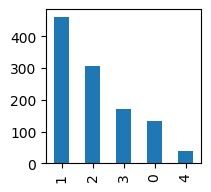

In [81]:
validation_raw['FLOOR'].value_counts().plot(kind='bar', figsize=(2,2))

- In this case, the class imbalance corresponds in both cases to Floor 04, however, this may be due to the fact that only one Building has Floor 4

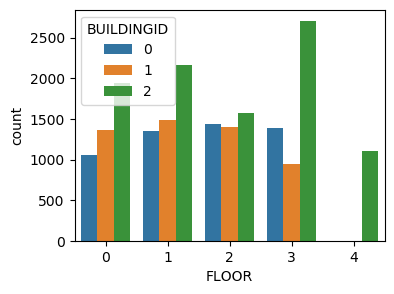

In [85]:
plt.figure(figsize=(4,3))
sns.countplot(x='FLOOR', hue='BUILDINGID', data=training_raw, orient='v')

- Only the building 02 has 5 different floors
- In general it is very important to have balanced classes in our datasets to avoid missclassifications, however, and due to the different imbalance in both datasets for this specific case, downsampling techniques did not yielded to better results.

### Latitude and Longitude Distribution

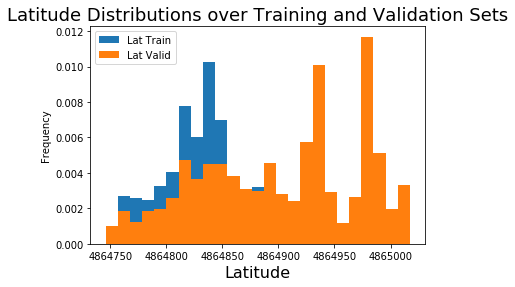

In [42]:
latitudes = pd.DataFrame({'Lat Train': training_raw['LATITUDE'],
                          'Lat Valid': validation_raw['LATITUDE']},
                         columns=['Lat Train', 'Lat Valid'])

latitudes.plot.hist(bins=25, density=True, histtype='bar')
plt.title("Latitude Distributions over Training and Validation Sets", fontsize=18)
plt.xlabel("Latitude", fontsize=16)
plt.legend(loc='best')
plt.show()

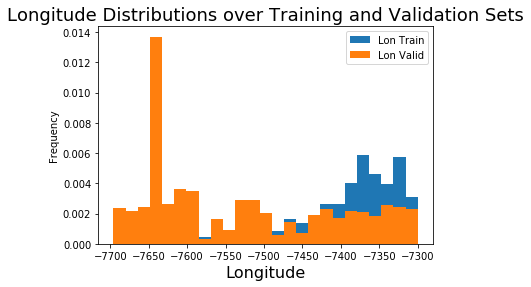

In [45]:
longitudes = pd.DataFrame({'Lon Train': training_raw['LONGITUDE'],
                           'Lon Valid': validation_raw['LONGITUDE']},
                          columns=['Lon Train', 'Lon Valid'])

longitudes.plot.hist(bins=25, density=True, histtype='bar')
plt.title("Longitude Distributions over Training and Validation Sets", fontsize=18)
plt.xlabel("Longitude", fontsize=16)
plt.legend(loc='best')
plt.show()

- Validation and Train Datasets exhibits different distributions of Latitude and Longitude, this confirm our previous observation: Building 00 has more observations in the dataset.
- Some observations from Building 00 in the validation set could be translated to the test set to enrich the model.
- However, this was out of the scope of this Task.

### WAPS distribution

In [88]:
# Counting the number of ocurrences different to 100 (which is no signal)

# Training Data
training_raw['WAP_COUNT'] = training_raw[training_raw.iloc[:,0:520] != 100].count(axis=1)
# If 1 or columns counts are generated for each row. Also: axis='columns'

# Validation Data
validation_raw['WAP_COUNT'] = validation_raw[validation_raw.iloc[:,:-9] != 100].count(axis=1)

In [89]:
# BUILDING SUBSETTING FOR CHECKING DISTRIBUTION

# Training Data
Build00_train = training_raw[training_raw['BUILDINGID'] == 0]
Build01_train = training_raw[training_raw['BUILDINGID'] == 1]
Build02_train = training_raw[training_raw['BUILDINGID'] == 2]
# Test Data
Build00_valid = validation_raw[validation_raw['BUILDINGID'] == 0]
Build01_valid = validation_raw[validation_raw['BUILDINGID'] == 1]
Build02_valid = validation_raw[validation_raw['BUILDINGID'] == 2]

# WAP counts per building - Training Data

Building_WAP_train = pd.DataFrame({'Building 00': Build00_train['WAP_COUNT'],
                                   'Building 01': Build01_train['WAP_COUNT'],
                                   'Building 02': Build02_train['WAP_COUNT']},
                                  columns=['Building 00',
                                           'Building 01',
                                           'Building 02'])

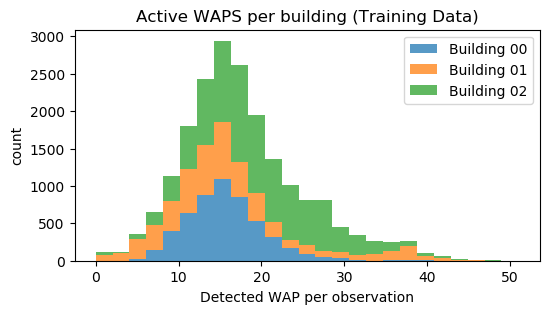

In [95]:
Building_WAP_train.plot.hist(stacked=True,
                             figsize=(6, 3),
                             alpha=0.75,
                             bins=25)

plt.title("Active WAPS per building (Training Data)")
plt.xlabel("Detected WAP per observation")
plt.ylabel('count')
plt.legend(loc='best')

plt.show()

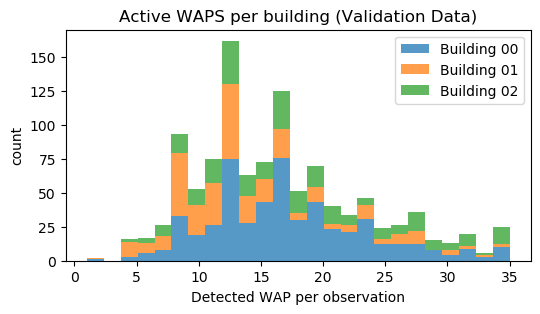

In [96]:
#WAP counts per building - Validation Data

Building_WAP_valid = pd.DataFrame({'Building 00': Build00_valid['WAP_COUNT'],
                                   'Building 01': Build01_valid['WAP_COUNT'],
                                   'Building 02': Build02_valid['WAP_COUNT']},
                                  columns=['Building 00',
                                           'Building 01',
                                           'Building 02'])

Building_WAP_valid.plot.hist(stacked=True,
               figsize=(6,3),
               alpha=0.75,
               bins=25)

plt.title("Active WAPS per building (Validation Data)")
plt.xlabel("Detected WAP per observation")
plt.ylabel('count')
plt.legend(loc='best')

plt.show()

- In general, the observations were detected by a range of 10 - 30 different WAPS.

## Pre-processing

**There are several things that will be adressed in the pre-processing part:**
- Latitude and Longitude will be rotated to minimize the total surface area
- The WAPS and the observations that are alway 100 (no detection) will be removed
- Duplicated will be removed
- Near zero variance WAPS will be removed (they always detect the same area)
- Outliers will be analyzed and removed
- Data will be re-scaled to positive numbers
- Normalization over the rows is performed
- Principal component analysis is done with the objective of minimize the computing time

**Notes:**

- WAPS are measured in RSSI (dBm), which is a logarithm scale. Power transformation to mW was tried, following the next equation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$$P(mW)=1mW*10^{P(dBm)/10}$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;However, the results were not as expected, and it was not included in this report. More info:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/)
- Due to the high skewness of the WAPS, it os logical to thing that a method that normalization and standarization is not optimum, since it affects to outliers. Therefore, minmaxscaler function was tested. However, normalization yielded better results

### Rotation of the Latitude and Longitude

- As seen in the previous figures, latitude and longitude are rotated, therefore, the surface area covered by them is big. If we rotate coordinates, the final surface area for prediction will be smaller, giving rise to a decreasment of probability of bad prediction.
- Rotation was done following the rotation matrix, as follows:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $$\binom{x'}{y'}=\binom{cos\theta \; -sin\theta}{sin\theta \; cos\theta}\binom{x}{y}$$
where $\theta$ is calculated by Pitagoras theorem

In [5]:
#Rotation angle calculation
angle = np.arctan(training_raw["LATITUDE"][0]/training_raw["LONGITUDE"][0])
angle=angle/pi

In [6]:
#Rotation
longitude_rotate = training_raw["LONGITUDE"]*np.cos(angle) + training_raw["LATITUDE"]*np.sin(angle)
latitude_rotate = training_raw["LATITUDE"]*np.cos(angle) - training_raw["LONGITUDE"]*np.sin(angle)

v_longitude_rotate = validation_raw["LONGITUDE"]*np.cos(angle) + validation_raw["LATITUDE"]*np.sin(angle)
v_latitude_rotate = validation_raw["LATITUDE"]*np.cos(angle) - validation_raw["LONGITUDE"]*np.sin(angle)


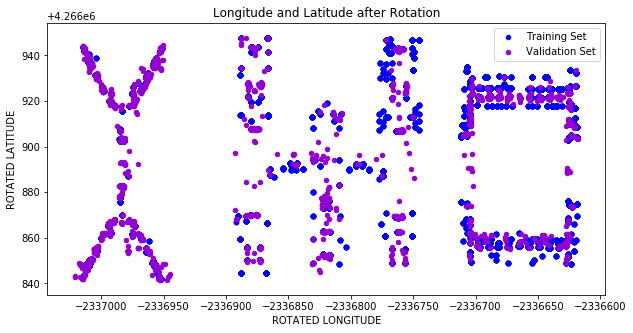

In [12]:
#Plotting to verify
rotation=pd.concat([longitude_rotate,latitude_rotate], axis=1)
rotation.columns = ["LONGITUDE", "LATITUDE"]

v_rotation=pd.concat([v_longitude_rotate,v_latitude_rotate], axis=1)
v_rotation.columns = ["LONGITUDE", "LATITUDE"]


ax1 = rotation.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                    label = 'Training Set',
                    color='blue',
                    figsize=(10,5))
ax2 = v_rotation.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                    label = 'Validation Set',
                    color="darkviolet",
                    figsize=(10,5),
                    ax=ax1)

plt.title('Longitude and Latitude after Rotation')
plt.xlabel('ROTATED LONGITUDE')
plt.ylabel('ROTATED LATITUDE')
plt.legend(loc='best')
plt.show()

In [13]:
#Adding rotated data to the dataframe
training_raw["LONGITUDE"] = longitude_rotate
training_raw["LATITUDE"] = latitude_rotate

validation_raw["LONGITUDE"] = v_longitude_rotate
validation_raw["LATITUDE"] = v_latitude_rotate


### WAPS 100 removal 

In [14]:
validation_clean = validation_raw.copy()

# Identification of the WAP columns with only 100 Signal Strengh

# Training dataset
train_column_select = np.sum(training_raw, axis=0) # Iterating over the columns
train_column_select = train_column_select[train_column_select == 1993700]
# If all the rows have 100, the 19937 rows will be this value
print("Columns with only 100 WAPS (Training):", train_column_select.count())

# Test dataset
valid_column_select = np.sum(validation_raw, axis=0)
valid_column_select = valid_column_select[valid_column_select == 111100]
print("Columns with only 100 WAPS (Validation):", valid_column_select.count())

# Training dataset
train_row_select = training_raw.iloc[:, 0:520]
train_row_select = np.sum(train_row_select, axis=1)
train_row_select = train_row_select[train_row_select == 52000]
print('Rows with only 100 WAPS (Training):', train_row_select.count())

# Test dataset
valid_row_select = validation_raw.iloc[:, 0:520]
valid_row_select = np.sum(valid_row_select, axis=1)
valid_row_select = valid_row_select[valid_row_select == 52000]
print('Rows with only 100 WAPS (Validation):', valid_row_select.count())

# Remove the columns
# Training dataset
training_clean = training_raw[training_raw.columns[training_raw.sum() != 1993700]]
print("After column removal:", training_clean.shape)

# Remove the rows
# Training dataset
training_clean.columns.get_loc("LONGITUDE")
training_row_cleaning = training_clean.iloc[:, 0:465]
training_row_cleaning['rows'] = np.sum(training_row_cleaning, axis=1)
training_clean = training_clean.drop(training_clean.index[training_row_cleaning.rows == 46500])
print("After row removal:", training_clean.shape)

Columns with only 100 WAPS (Training): 55
Columns with only 100 WAPS (Validation): 153
Rows with only 100 WAPS (Training): 76
Rows with only 100 WAPS (Validation): 0
After column removal: (19937, 474)
After row removal: (19861, 474)


### Remove duplicates

In [15]:
# REMOVE DUPLICATE ROWS

# Training dataset
training_clean = training_clean.drop_duplicates()

# Test dataset
validation_clean = validation_clean.drop_duplicates()

print("After duplicates removal:", training_clean.shape)

After duplicates removal: (19227, 474)


### Remove low variance WAPS

In [17]:
#%% VARIANCE OF THE WAPS

print("Before Removing low variance WAPS:", training_clean.shape)
# Training dataset
COLUMN_NAMES=[]
train_var = pd.DataFrame(columns=COLUMN_NAMES)
train_var['variance'] = training_clean.var(axis=0)
train_var.describe()
#train_var.drop(train_var.index[465:476], inplace=True)

# Transpose the column with row

# Training dataset
train_var_trans = train_var.T
train_var_trans.dtypes
train_var_trans = train_var_trans.astype('int')

#Set variance threshold (less than 10 - it give us Boolean) 
#and combine it with the main dataset

train_var_trans = train_var_trans.iloc[-1:,:] < 10 
#Iterate over the last row of the dataframe
#If I do not put the last ",:" I get a series (row form data set)
#Moreover, if I put the row name variance it does not work

train_combine= pd.concat([train_var_trans, training_clean]) #With this appear as the first
#train_combine_test2 = training_clean.append(train_var_trans) #With this appear at the end

#Replace all 1 with NaN
train_combine.columns.get_loc("LONGITUDE") #475-465
train_combine.iloc[:,:-10] = train_combine.replace(to_replace=1, value=np.nan)

#Remove all column with NaN
train_combine.dropna(axis=1, inplace = True)

#Remove row variance
train_combine = train_combine.drop(train_combine.index[0])

#Cleaned data asigment
train_clean = train_combine.copy()
print("After Removing low variance WAPS:", train_clean.shape)


Before Removing low variance WAPS: (19227, 474)
After Removing low variance WAPS: (19227, 423)


**TIMESTAMP**
- The unix time stamp is a way to track time as a running total of seconds. This count starts at the Unix Epoch on January 1st, 1970 at UTC. Therefore, the unix time stamp is merely the number of seconds between a particular date and the Unix Epoch.

In [18]:
train_clean['TIMESTAMP'] = pd.to_datetime(train_clean['TIMESTAMP'], unit='s')
train_clean.TIMESTAMP

# Test dataset
validation_clean['TIMESTAMP'] = pd.to_datetime(validation_clean['TIMESTAMP'], unit='s')
validation_clean.TIMESTAMP

0      2013-10-04 07:45:03
1      2013-10-07 14:10:54
2      2013-10-07 14:11:35
3      2013-10-07 14:12:18
4      2013-10-04 09:09:34
               ...        
1106   2013-10-07 14:38:31
1107   2013-10-07 14:38:50
1108   2013-10-08 15:56:21
1109   2013-10-08 15:56:47
1110   2013-10-08 15:57:16
Name: TIMESTAMP, Length: 1111, dtype: datetime64[ns]

### Data splitting before data transformation

In [20]:
#Independent variables
X_training = train_clean.iloc[:,:-9] #iloc is index location i.e. row number #get all rows for columns until 520
X_validation = validation_clean.iloc[:,:-9] 

#To ensure to have the same columns!!!!!
X_validation = X_validation[X_training.columns]

#Dependent variables
Y_training = train_clean.iloc[:,-9:len(train_clean)]
Y_validation = validation_clean.iloc[:,-9:len(train_clean)]

In [21]:
#Remove unnecessary colums

# Training dataset
y_training = Y_training.drop(['SPACEID', 'RELATIVEPOSITION', 
                                'USERID', 'PHONEID', 'TIMESTAMP'], axis=1)

# Test dataset
y_validation = Y_validation.drop(['SPACEID', 'RELATIVEPOSITION',
                                    'USERID', 'PHONEID', 'TIMESTAMP'], axis=1)

y_training.FLOOR = y_training.FLOOR.astype('category')
y_training.BUILDINGID = y_training.BUILDINGID.astype('category')

y_validation.FLOOR = y_validation.FLOOR.astype('category')
y_validation.BUILDINGID = y_validation.BUILDINGID.astype('category')

y_training

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,-2.336880e+06,4.266908e+06,2,1
1,-2.336883e+06,4.266922e+06,2,1
2,-2.336875e+06,4.266944e+06,2,1
3,-2.336872e+06,4.266927e+06,2,1
5,-2.336883e+06,4.266928e+06,2,1
...,...,...,...,...
19932,-2.336809e+06,4.266894e+06,3,1
19933,-2.336707e+06,4.266906e+06,1,2
19934,-2.336844e+06,4.266892e+06,3,1
19935,-2.336865e+06,4.266888e+06,3,1


### Checking Outliers

According to:
https://support.randomsolutions.nl/827069-Best-dBm-Values-for-Wifi
https://www.metageek.com/training/resources/understanding-rssi.html

The maximum achievable real strength corresponds to -30dBm, while the optimum signal corresponds to the range -40 and -60 dBm. We are going to check the distribution of signals of the WAP to obsever how the range between -30 and 0 dBm behaves.

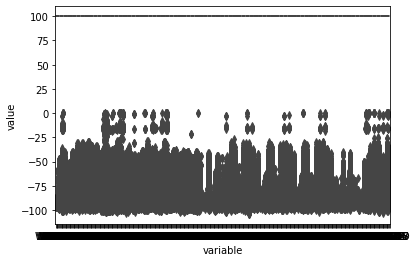

In [22]:
sns.boxplot(x="variable", y="value", data=pd.melt(X_training))

From the distribution observed, it seems clear that the values above -30dBm are unusual, therefore, we will consider them as outliers and remove them

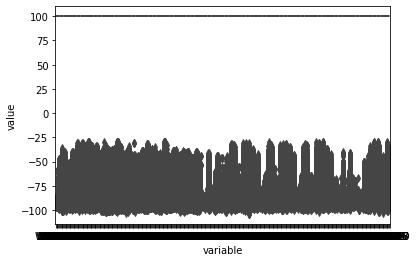

In [23]:
#Reset the index to avoid possible problems
X_training.reset_index(drop = True, inplace = True)
y_training.reset_index(drop = True, inplace = True)

#Find the index where we have the outliers
index_outliers = X_training[(X_training.iloc[:,:].values > -30) & (X_training.iloc[:,:].values <= 0)].index
#Drop the observations of the outliers
X_training = X_training.drop(X_training.index[index_outliers])
#Drop the observation also in the Y_training
y_training = y_training.drop(y_training.index[index_outliers])

sns.boxplot(x="variable", y="value", data=pd.melt(X_training))

### Data re-scaling

In [24]:
X_train_scale = np.where(X_training <= 0, #If it is lower than 0
                                     X_training + 105, #Sum 105
                                     X_training - 100) #Otherwise, substract 100
#Reconvert it into dataframe
X_train_scale_df = pd.DataFrame(X_train_scale, columns = X_training.columns)

X_validation_scale = np.where(X_validation <= 0, #If it is lower than 0
                                     X_validation + 105, #Sum 105
                                     X_validation - 100) #Otherwise, substract 100
#Reconvert it into dataframe
X_validation_scale_df = pd.DataFrame(X_validation_scale, columns = X_validation.columns)

### Normalization

In [25]:
#l2 normalization over rows

normalizer = Normalizer()

X_norm_train = normalizer.fit_transform(X_train_scale_df)
X_norm_validation= normalizer.fit_transform(X_validation_scale_df)

#Reconverting in Dataframe
X_norm_train_df = pd.DataFrame(X_norm_train, columns = X_training.columns)
X_norm_validation_df = pd.DataFrame(X_norm_validation, columns = X_validation.columns)

X_norm_train_df


,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP509,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.080866,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18730,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18731,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18732,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18733,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Principal Component Analysis

 - PCA is an unsupervised feature engineering technique that reduces the dimensionality of the dataset to a handful of variables
 - In this case, we reduced the number of variables to the point that retained the 98% of the variance

Before PCA: (18735, 414)
After PCA: (18735, 183)


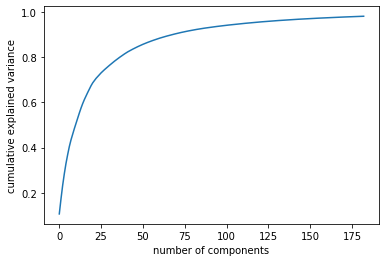

In [26]:
print("Before PCA:", X_norm_train_df.shape)
pca = PCA(.98) #98% of the variance is retained.
pca.fit(X_norm_train_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


X_train_pca = pca.transform(X_norm_train_df)
X_validation_pca = pca.transform(X_norm_validation_df)
print("After PCA:", X_train_pca.shape)

#Variable renaming
X_training=X_train_pca.copy()
X_validation=X_validation_pca.copy()

## Modelling

- Different models were tried with the final data, including KNN, Random Forest, SVM a XGBoosting Tree
- The models were optimized throughotu RandomizedSearchSV in a previous script (GitHub). Therefore, in this report, the modellling analysis with the optimized parameters will be performed.
- Cascading approach was tested in previous scripts (Github), but the results were slightly worse for Latitude and Longitude, therefore, the final predictions will be done without Cascading.


### Algorithms for the models

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



### Predict Building

In [29]:
#Algorithms for Building prediction
models = []
models.append(('RF', RandomForestClassifier(n_estimators=300)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=6)))
models.append(('SVM', SVC(kernel= 'rbf', C= 0.1)))
models.append(('XGB', XGBClassifier(n_estimators=800, learning_rate=0.2)))
 
# evaluate each model in turn
accuracy_building = []
kappa_building= []
names = []
predictions_building =[]
for name, model in models:
    if (model == 'XGB'):
        model.fit(X_training, y_training['BUILDINGID'], 
              early_stopping_rounds=5, #overfitting prevention, stop early if no improvement in learning
              eval_set=[(X_validation, y_validation['BUILDINGID'])])
        prediction = model.predict(X_validation)
        predictions_building.append(prediction)
        accuracy= accuracy_score(y_validation['BUILDINGID'], prediction)
        accuracy_building.append(accuracy)
        kappa= cohen_kappa_score(y_validation['BUILDINGID'], prediction)
        kappa_building.append(kappa)
        names.append(name) 
    else:
        model.fit(X_training,y_training['BUILDINGID'])
        prediction = model.predict(X_validation)
        predictions_building.append(prediction)
        accuracy= accuracy_score(y_validation['BUILDINGID'], prediction)
        accuracy_building.append(accuracy)
        kappa= cohen_kappa_score(y_validation['BUILDINGID'], prediction)
        kappa_building.append(kappa)
        names.append(name)


#### Building Metrics

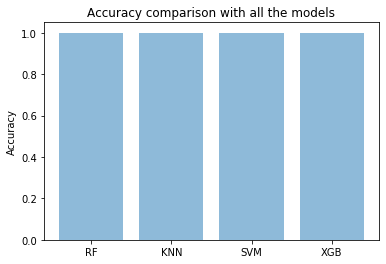

Accuracy list: [1.0, 1.0, 1.0, 0.9990999099909991]


In [36]:
plt.bar(names, accuracy_building, align='center', alpha=0.5)
plt.ylabel('Accuracy')
plt.title('Accuracy comparison with all the models')
plt.show()
print("Accuracy list:", accuracy_building)

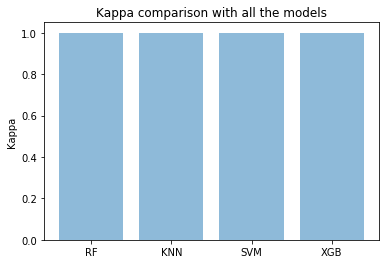

Kappa list: [1.0, 1.0, 1.0, 0.9985769600741876]


In [38]:
plt.bar(names, kappa_building, align='center', alpha=0.5)
plt.ylabel('Kappa')
plt.title('Kappa comparison with all the models')
plt.show()
print("Kappa list:", kappa_building)

- All the models, excepting XGBoosting yielded an accuracy of 1.0, therefore, any of them could be selected.

#### Final Building Prediction

In [32]:
predictions_building=pd.DataFrame(predictions_building)
predictions_building=predictions_building.T
predictions_building.columns = ['RF', 'KNN', 'SVM', 'XGB']
predictions_building
predictions_building.to_csv("predictions_building.csv")


### Predicting Floor

In [23]:
#Algorithms for Building prediction
models = []
models.append(('RF', RandomForestClassifier(n_estimators=300)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2)))
models.append(('SVM', SVC(kernel= 'poly', C= 100)))
models.append(('XGB', XGBClassifier(n_estimators=1100, learning_rate=0.4)))
 
# evaluate each model in turn
accuracy_floor = []
kappa_floor= []
names = []
predictions_floor =[]
for name, model in models:
    if (model == 'XGB'):
        model.fit(X_training, y_training['FLOOR'], 
              early_stopping_rounds=5, #overfitting prevention, stop early if no improvement in learning
              eval_set=[(X_validation, y_validation['FLOOR'])])
        prediction = model.predict(X_validation)
        predictions_floor.append(prediction)
        accuracy= accuracy_score(y_validation['FLOOR'], prediction)
        accuracy_floor.append(accuracy)
        kappa= cohen_kappa_score(y_validation['FLOOR'], prediction)
        kappa_floor.append(kappa)
        names.append(name) 
    else:
        model.fit(X_training,y_training['FLOOR'])
        prediction = model.predict(X_validation)
        predictions_floor.append(prediction)
        accuracy= accuracy_score(y_validation['FLOOR'], prediction)
        accuracy_floor.append(accuracy)
        kappa= cohen_kappa_score(y_validation['FLOOR'], prediction)
        kappa_floor.append(kappa)
        names.append(name)



#### Floor Metrics

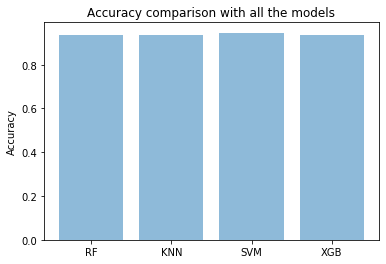

Accuracy list: [0.936993699369937, 0.936993699369937, 0.945994599459946, 0.9360936093609361]


In [40]:
plt.bar(names, accuracy_floor, align='center', alpha=0.5)
plt.ylabel('Accuracy')
plt.title('Accuracy comparison with all the models')
plt.show()
print("Accuracy list:", accuracy_floor)

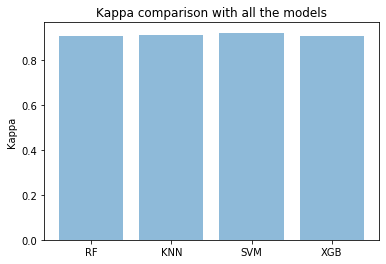

Kappa list: [0.9112050402014984, 0.9116650518685278, 0.923944915399272, 0.9101410180319447]


In [44]:
plt.bar(names, kappa_floor, align='center', alpha=0.5)
plt.ylabel('Kappa')
plt.title('Kappa comparison with all the models')
plt.show()
print("Kappa list:", kappa_floor)

 - In this case, the best model was the SVM, giving an accuracy of 94%

#### Final Floor Prediction

In [28]:
predictions_floor=pd.DataFrame(predictions_floor)
predictions_floor=predictions_floor.T
predictions_floor.columns = ['RF', 'KNN', 'SVM', 'XGB']
predictions_floor
predictions_floor.to_csv("predictions_floor.csv")

### Predicting Latitude

In [40]:
#Algorithms for Building prediction
models = []
models.append(('RF', RandomForestRegressor(n_estimators=1000)))
models.append(('KNN', KNeighborsRegressor(n_neighbors=7)))
models.append(('SVM', SVR(kernel= 'rbf', C= 100)))
models.append(('XGB', XGBRegressor(n_estimators=1100, learning_rate=0.5)))
 
# evaluate each model in turn
RMSE_latitude = []
MAE_latitude= []
R2_latitude=[]
names = []
predictions_latitude = []
for name, model in models:
    if (model == 'XGB'):
        model.fit(X_training, y_training['LATITUDE'], 
              early_stopping_rounds=5, #overfitting prevention, stop early if no improvement in learning
              eval_set=[(X_validation, y_validation['LATITUDE'])])
        prediction = model.predict(X_validation)
        predictions_latitude.append(prediction)
        rmse= sqrt(mean_squared_error(y_validation['LATITUDE'], prediction))
        RMSE_latitude.append(rmse)
        mae= mean_absolute_error(y_validation['LATITUDE'], prediction)
        MAE_latitude.append(mae)
        r2=r2_score(y_validation['LATITUDE'], prediction)
        R2_latitude.append(r2)
        names.append(name)        
    else:
        model.fit(X_training,y_training['LATITUDE'])
        prediction = model.predict(X_validation)
        predictions_latitude.append(prediction)
        rmse= sqrt(mean_squared_error(y_validation['LATITUDE'], prediction))
        RMSE_latitude.append(rmse)
        mae= mean_absolute_error(y_validation['LATITUDE'], prediction)
        MAE_latitude.append(mae)
        r2=r2_score(y_validation['LATITUDE'], prediction)
        R2_latitude.append(r2)
        names.append(name)

[14:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Latitude Metrics

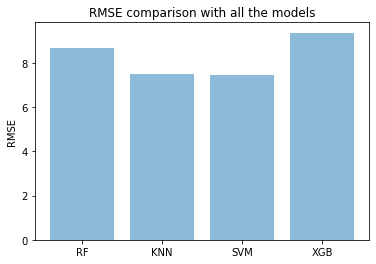

RMSE list: [8.657303070701275, 7.503499244365031, 7.467752985829599, 9.363908374637642]


In [46]:
plt.bar(['RF', 'KNN', 'SVM', 'XGB'], RMSE_latitude, align='center', alpha=0.5)
plt.ylabel('RMSE')
plt.title('RMSE comparison with all the models')
plt.show()
print("RMSE list:", RMSE_latitude)

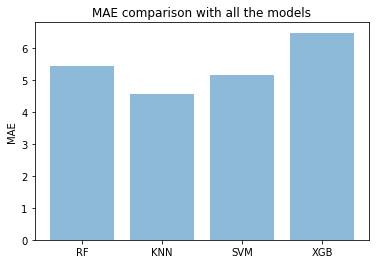

MAE list: [5.444242792981102, 4.5644336594696195, 5.149404948134676, 6.489613013267417]


In [48]:
plt.bar(['RF', 'KNN', 'SVM', 'XGB'], MAE_latitude, align='center', alpha=0.5)
plt.ylabel('MAE')
plt.title('MAE comparison with all the models')
plt.show()
print("MAE list:", MAE_latitude)

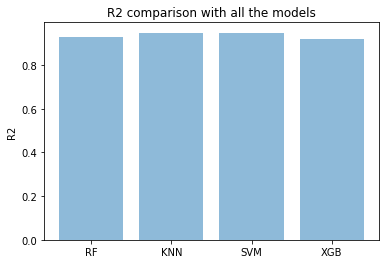

R2 list: [0.9301472820231689, 0.9475258088733189, 0.9480245862949438, 0.9182792436497792]


In [51]:
plt.bar(['RF', 'KNN', 'SVM', 'XGB'], R2_latitude, align='center', alpha=0.5)
plt.ylabel('R2')
plt.title('R2 comparison with all the models')
plt.show()
print("R2 list:", R2_latitude)

- For longitude predictions, there are two models that are the best candidates, KNN and SVM (distance based models). 
- However, analysing the MAE, it is suggested that KNN performs slightly better than KNN.

#### Final Latitude Prediction

In [44]:
predictions_latitude=pd.DataFrame(predictions_latitude)
predictions_latitude=predictions_latitude.T
predictions_latitude.columns = ['RF', 'KNN', 'SVM', 'XGB']
predictions_latitude
predictions_latitude.to_csv("predictions_latitude.csv")

### Predicting Longitude

In [45]:
#Algorithms for Longitude prediction
models = []
models.append(('RF', RandomForestRegressor(n_estimators=800)))
models.append(('KNN', KNeighborsRegressor(n_neighbors=6)))
models.append(('SVM', SVR(kernel= 'rbf', C= 100)))
models.append(('XGB', XGBRegressor(n_estimators=1100, learning_rate=0.4)))
 
# evaluate each model in turn
RMSE_longitude = []
MAE_longitude= []
R2_longitude=[]
names = []
predictions_longitude = []
for name, model in models:
    if (model == 'XGB'):
        model.fit(X_training, y_training['LONGITUDE'], 
              early_stopping_rounds=5, #overfitting prevention, stop early if no improvement in learning
              eval_set=[(X_validation, y_validation['LONGITUDE'])])
        prediction = model.predict(X_validation)
        predictions_longitude.append(prediction)
        rmse= sqrt(mean_squared_error(y_validation['LONGITUDE'], prediction))
        RMSE_longitude.append(rmse)
        mae= mean_absolute_error(y_validation['LONGITUDE'], prediction)
        MAE_longitude.append(mae)
        r2=r2_score(y_validation['LONGITUDE'], prediction)
        R2_longitude.append(r2)
        names.append(name)        
    else:
        model.fit(X_training,y_training['LONGITUDE'])
        prediction = model.predict(X_validation)
        predictions_longitude.append(prediction)
        rmse= sqrt(mean_squared_error(y_validation['LONGITUDE'], prediction))
        RMSE_longitude.append(rmse)
        mae= mean_absolute_error(y_validation['LONGITUDE'], prediction)
        MAE_longitude.append(mae)
        r2=r2_score(y_validation['LONGITUDE'], prediction)
        R2_longitude.append(r2)
        names.append(name)

[14:50:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Longitude Metrics

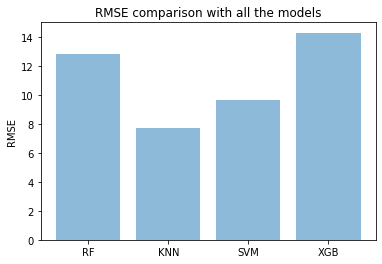

RMSE list: [12.817578115985151, 7.691828570608746, 9.67027466608156, 14.310512463065672]


In [53]:
plt.bar(names, RMSE_longitude, align='center', alpha=0.5)
plt.ylabel('RMSE')
plt.title('RMSE comparison with all the models')
plt.show()
print("RMSE list:", RMSE_longitude)

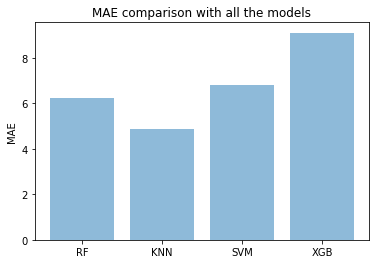

MAE list: [6.2299458444966, 4.883254885693642, 6.815358467133503, 9.111209546249782]


In [55]:
plt.bar(names, MAE_longitude, align='center', alpha=0.5)
plt.ylabel('MAE')
plt.title('MAE comparison with all the models')
plt.show()
print("MAE list:", MAE_longitude)

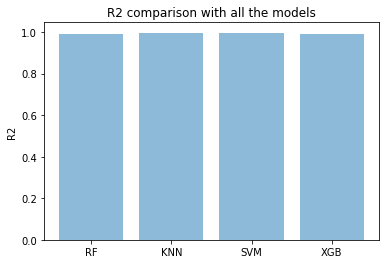

RMSE list: [0.9910214765374433, 0.9967666540886267, 0.9948894152435442, 0.9888081121770947]


In [57]:
plt.bar(names, R2_longitude, align='center', alpha=0.5)
plt.ylabel('R2')
plt.title('R2 comparison with all the models')
plt.show()
print("RMSE list:", R2_longitude)

- In this case, it is clear that the best model is KNN.
- Longitude predictions performs slighlt worse than latitude, we will further check this in the Error Analysis.

#### Final Longitude Prediction

In [49]:
predictions_longitude=pd.DataFrame(predictions_longitude)
predictions_longitude=predictions_longitude.T
predictions_longitude.columns = ['RF', 'KNN', 'SVM', 'XGB']
predictions_longitude
predictions_longitude.to_csv("predictions_longitude.csv")

## Calculate Competition Score

- With the objective of having a rough idea of how well the model performes, we will check the competition score given by UJI

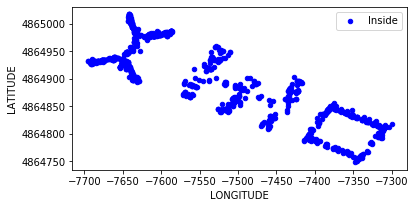

In [61]:
#Return to the original orientation - Validation

v_longitude_back = y_validation["LONGITUDE"]*np.cos(angle) - y_validation["LATITUDE"]*np.sin(angle)
v_latitude_back = y_validation["LATITUDE"]*np.cos(angle) + y_validation["LONGITUDE"]*np.sin(angle)

v_NOrotation=pd.concat([v_longitude_back,v_latitude_back], axis=1)
v_NOrotation.columns = ["LONGITUDE", "LATITUDE"]

#Verify
v_NOrotation.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                    label = 'Inside',
                    color='blue',
                    figsize=(6,3))
plt.show()

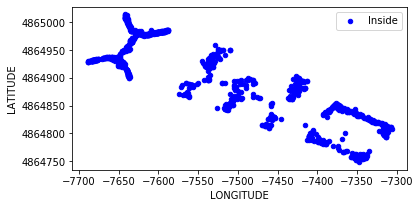

In [60]:
#Return to the original orientation - Predictions

pred_longitude_back_KNN = predictions_longitude["KNN"]*np.cos(angle) -predictions_latitude["KNN"]*np.sin(angle)
pred_latitude_back_KNN = predictions_latitude["KNN"]*np.cos(angle) + predictions_longitude["KNN"]*np.sin(angle)

pred_NOrotation_KNN=pd.concat([pred_longitude_back_KNN,pred_latitude_back_KNN], axis=1)
pred_NOrotation_KNN.columns = ["LONGITUDE", "LATITUDE"]

#Verify
pred_NOrotation_KNN.plot(kind='scatter', x="LONGITUDE", y="LATITUDE",
                    label = 'Inside',
                    color='blue',
                    figsize=(6,3))
plt.show()

In [62]:
#Change data types to be able to operate with them
y_validation.FLOOR=y_validation.FLOOR.astype('float32')
y_validation.BUILDINGID=y_validation.BUILDINGID.astype('float32')

In [63]:
#COMPETITION SCORE WITH CORRECT ROTATION

# Calculate the Euclidian distance between prediction and actual value (assuming FLAT EARTH)
distance_squared = (v_NOrotation.loc[:, "LATITUDE"] - pred_NOrotation_KNN["LATITUDE"])**2 + (v_NOrotation.loc[:, "LONGITUDE"] - pred_NOrotation_KNN["LONGITUDE"])**2
distance_root = distance_squared.apply(lambda x: sqrt(x))
# Calculate penalyty for misclassifying floor
bad_floor = np.abs(predictions_floor['SVM'] - y_validation.loc[:, "FLOOR"]) * 4
# Calculate penalyty for misclassifying building
bad_building = predictions_building['RF'] != y_validation.loc[:, "BUILDINGID"] * 50
# Calculate final score using distance, floor, and building
distance75 = np.percentile(distance_root + bad_floor + bad_building, 75)
distance75


10.849244849907853

## Error Analysis

### Floor Errors

In [71]:
#Plotting wrong floors predictions
y_validation_floorpred=y_validation.copy()
y_validation_floorpred["FLOOR_pred"]=predictions_floor["SVM"]
y_validation_floorpred

#We have to add the unrotated latitudes and longitudes to the original validation set
y_validation["LONGITUDE"]=v_longitude_back
y_validation["LATITUDE"]=v_latitude_back

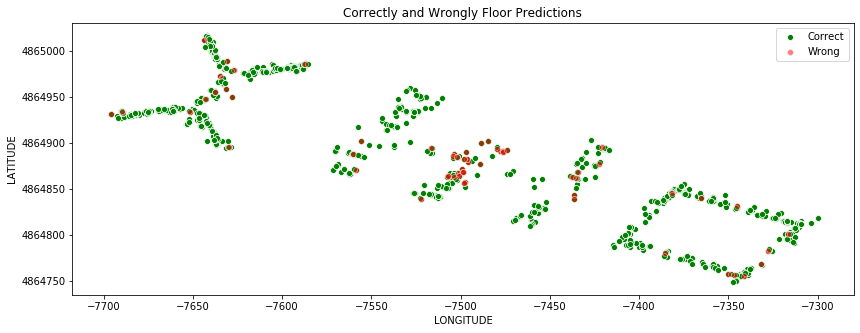

In [72]:
#Subsetting the wrong predictions
wrong_pred_floor = y_validation_floorpred[y_validation_floorpred['FLOOR'] != y_validation_floorpred['FLOOR_pred']]

#plotting wrong predictions for Floor (in red) and correct predictions (green)

fig, ax = plt.subplots(1, 1, figsize = (14, 5))

sns.scatterplot(y_validation_floorpred['LONGITUDE'],y_validation_floorpred['LATITUDE'],color='green')
sns.scatterplot(wrong_pred_floor['LONGITUDE'],wrong_pred_floor['LATITUDE'],color='red',alpha=0.5)
ax.set_title('Correctly and Wrongly Floor Predictions')
ax.legend(['Correct','Wrong'])

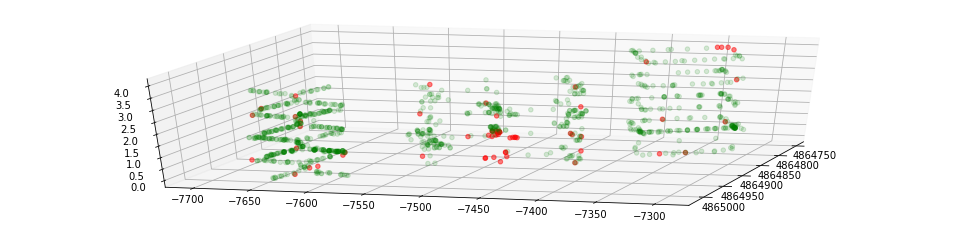

In [79]:
#3D plot, this time with seaborn
fig = plt.figure(figsize=(17, 4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y_validation_floorpred['LATITUDE'],y_validation_floorpred['LONGITUDE'],
           y_validation_floorpred["FLOOR_pred"], color='green', alpha=0.15)
ax.scatter(wrong_pred_floor['LATITUDE'], wrong_pred_floor['LONGITUDE'],
           wrong_pred_floor["FLOOR"], color='red', alpha=0.5)


ax.view_init(30, 15)
plt.show()

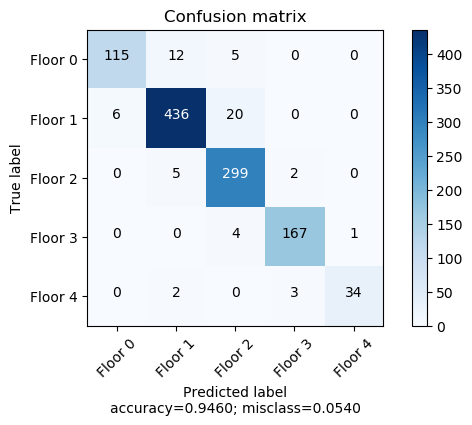

In [68]:
confmatrix_floor_SVM=confusion_matrix(y_validation['FLOOR'], prediction_floor['SVM'])
plot_confusion_matrix(confmatrix_floor_SVM,
                          target_names = ['Floor 0','Floor 1','Floor 2','Floor 3','Floor 4'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

- Most of the wrongly predicted floor classifications correspond to Building 01.
- If we go back to the 3D plots of the training Set, in Section 1.5.1 we can see that in Building 01, there are some Floors that have very few observations, thus giving rise to missclassifications.
- This suggest that making separate models splitting by building could help to further tunning the pre-processing and modelling steps for each building configuration

### Latitude & Longitude Errors

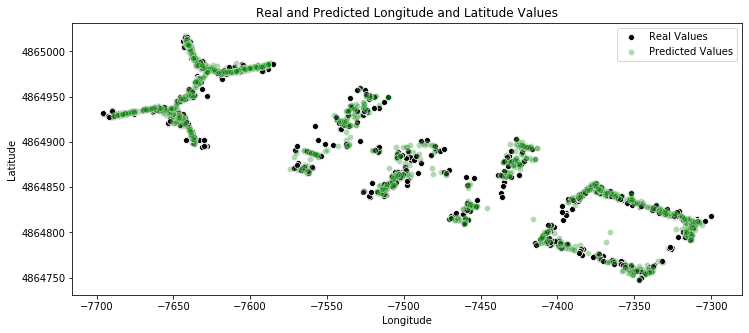

In [81]:
# plotting predictions for coordinates (green) and real coordinates(black)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.scatterplot(v_NOrotation['LONGITUDE'],
                v_NOrotation['LATITUDE'], color='black', alpha=1)
sns.scatterplot(pred_NOrotation_KNN['LONGITUDE'], 
                pred_NOrotation_KNN['LATITUDE'],
                color='green', alpha=0.3, legend='full')
ax.set(xlabel='Longitude', ylabel='Latitude')
ax.set_title('Real and Predicted Longitude and Latitude Values')
ax.legend(['Real Values', 'Predicted Values'])

- The bigger difference obseverved between real and predicted values come from Building 01, this is due to the fact that also gave us missclassifications on Floor predictions: some floors of this building are almost empty of observations.

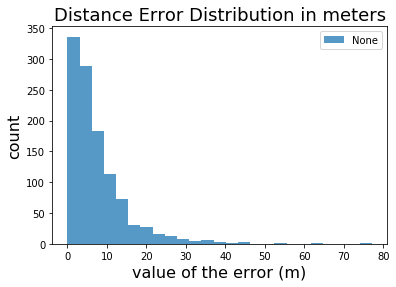

In [83]:
#Plotting the Distance error
distance_root.plot.hist(alpha=0.75,bins=25)
plt.title("Distance Error Distribution in meters", fontsize=18)
plt.xlabel('value of the error (m)', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.legend(loc='best')
plt.show()

- From the distribution of the distance error, we can see that most of the errors are lower than 10m.
- However, we have some outliers of 40 and 80m, probably due to the missclassification of the Floor.

[Text(0, 0.5, 'Residual'),
 Text(0.5, 0, 'Latitude'),
 Text(0.5, 1.0, 'Distribution of Residuals for Latitude')]

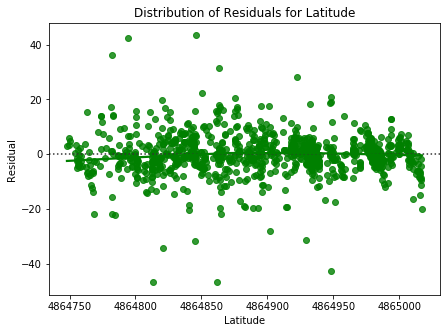

In [93]:
#Residual Plot Latitude
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.residplot(v_latitude_back, pred_latitude_back_KNN, lowess=True, color="g").set(
    title = 'Distribution of Residuals for Latitude', xlabel = 'Latitude', ylabel = 'Residual')


[Text(0, 0.5, 'Residual'),
 Text(0.5, 0, 'Longitude'),
 Text(0.5, 1.0, 'Distribution of Residuals for Longitude')]

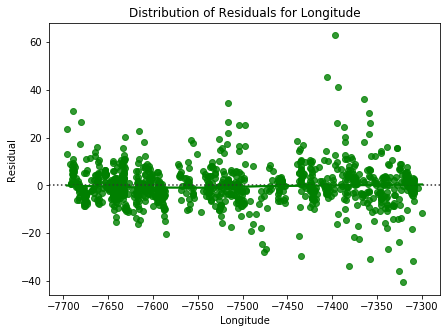

In [94]:
#Residual Plot Longitude
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.residplot(v_longitude_back, pred_longitude_back_KNN, lowess=True, color="g").set(
    title = 'Distribution of Residuals for Longitude', xlabel = 'Longitude', ylabel = 'Residual')

- In general, residuals for Latitude and Longitude are randomly distributed, which suggest that the selected models were appropiate to fit the data.
- Latitude prediction exhibit some outliers in the region of Building 01, again, the problematic one due to few observation in some floors.
- However, the outliers coming from Longitude predictions corresponds to building 02. Taking a look at the 3D plot of Section 1.5.1 we can infer that can be due to the fact that Floor 04 has one area empty of observations, and Floor 0 was poorly recorded.

## Conclusions

- We have developed a complete workflow for Wifi Locationing by RSSI intensity measurements.
- There was a clear needing of preprocess the data in order to avoid useless informations, such as the low variance or not working WAPS.
- Several extra steps were tried, showing here the ones that yielded better performance.
- Once selected the final dataset, RandomizedGridSearchCV was performed in all the models with objective of finding the best hyperparameters for each model.
- In general, the euclidian distance based models performed better than classification based model, this was expectable, due to the nature of our data.
- We have developed a robust model for predicting positioning, however, some improvements could be done if we would be able to acces to data of the areas that were poorly covered.